In [1]:
#title: "Financial anomaly detection with benford law"

#author: Erkan Çetinyamaç 

Veri Seti  IEEE-CIS tarafından oluşturulmuş bir sentetik data setidir. Fraud Detection problemleri üzerinde araştırma yapılması için oluşturulmuş bir data settir.

Link: https://www.kaggle.com/c/ieee-fraud-detection/data

In [2]:
library(plyr)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(benford.analysis)
library(rcompanion)
library(funModeling)


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

<U+221A> tibble  3.0.4     <U+221A> purrr   0.3.4
<U+221A> tidyr   1.1.2     <U+221A> stringr 1.4.0
<U+221A> readr   1.4.0     <U+221A> forcats 0.5.0

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag() 


Verideki varsa Eksik Gözlemlerin Silinmesi.

In [3]:


setwd("C:/Users/eceti/Desktop")

data<- read_csv("train_transaction.csv")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  ProductCD = col_character(),
  card4 = col_character(),
  card6 = col_character(),
  P_emaildomain = col_character(),
  R_emaildomain = col_character(),
  M1 = col_logical(),
  M2 = col_logical(),
  M3 = col_logical(),
  M4 = col_character(),
  M5 = col_logical(),
  M6 = col_logical(),
  M7 = col_logical(),
  M8 = col_logical(),
  M9 = col_logical()
)
i Use `spec()` for the full column specifications.




In [4]:
dim(data)

[1] 590540    394

Veride Varsa eksik değer temizlemek.

In [5]:
#colSums(is.na(data))

#na.omit(data)

Popülasyondan örneklem çekimi.

In [6]:
set.seed(2021)

df<-sample_n(data, 100000)

Veriyi indexlemek.

In [7]:
index<- c(1:100000)

df$index<-index

İlgili Featureları alınıyor.

In [8]:
df<-df[c("index","TransactionAmt","TransactionID","TransactionDT","ProductCD","card1","card2","card3","card4","card5" ,"card6")]


TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
TransactionAMT: transaction payment amount in USD
ProductCD: product code, the product for each transaction
card1 - card6: payment card information, such as card type, card category, issue bank.

Veriyi Tanıyalım.


In [9]:
glimpse(df)

Rows: 100,000
Columns: 11
$ index          <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1...
$ TransactionAmt <dbl> 107.950, 28.957, 92.950, 159.950, 87.950, 159.950, 2...
$ TransactionID  <dbl> 3431581, 3426179, 3201085, 3568142, 3310925, 3067274...
$ TransactionDT  <dbl> 11306966, 11128301, 4987680, 15520904, 8018026, 1727...
$ ProductCD      <chr> "W", "C", "W", "W", "W", "W", "W", "W", "W", "W", "W...
$ card1          <dbl> 11919, 9633, 2542, 12544, 11207, 10112, 13809, 11465...
$ card2          <dbl> 170, 130, 321, 321, 361, 360, 583, 360, 111, 268, 55...
$ card3          <dbl> 150, 185, 150, 150, 150, 150, 150, 150, 150, 150, 15...
$ card4          <chr> "mastercard", "visa", "visa", "visa", "visa", "visa"...
$ card5          <dbl> 224, 138, 226, 226, 226, 166, 226, 166, 226, 166, 22...
$ card6          <chr> "debit", "debit", "debit", "debit", "debit", "debit"...



Verinin istatistiksel özellikleri

In [10]:
summary(df)

profiling_num(df)

     index        TransactionAmt     TransactionID     TransactionDT     
 Min.   :     1   Min.   :    0.42   Min.   :2987002   Min.   :   86469  
 1st Qu.: 25001   1st Qu.:   42.95   1st Qu.:3135162   1st Qu.: 3035191  
 Median : 50001   Median :   68.95   Median :3283396   Median : 7326203  
 Mean   : 50001   Mean   :  135.11   Mean   :3282711   Mean   : 7384678  
 3rd Qu.: 75000   3rd Qu.:  125.00   3rd Qu.:3430270   3rd Qu.:11281044  
 Max.   :100000   Max.   :31937.39   Max.   :3577536   Max.   :15811049  
                                                                         
  ProductCD             card1           card2           card3      
 Length:100000      Min.   : 1004   Min.   :100.0   Min.   :100.0  
 Class :character   1st Qu.: 6019   1st Qu.:215.0   1st Qu.:150.0  
 Mode  :character   Median : 9681   Median :361.0   Median :150.0  
                    Mean   : 9899   Mean   :362.8   Mean   :153.2  
                    3rd Qu.:14182   3rd Qu.:512.0   3rd Qu.:150.0  


variable,mean,std_dev,variation_coef,p_01,p_05,p_25,p_50,p_75,p_95,p_99,skewness,kurtosis,iqr,range_98,range_80
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
index,50000.5000,2.886766e+04,0.57734738,1000.990,5000.950,25000.75,50000.50,75000.25,95000.05,99000.01,0.000000000,1.800000,49999.50,"[1000.99, 99000.01]","[10000.9, 90000.1]"
TransactionAmt,135.1070,2.514519e+02,1.86113214,9.244,20.059,42.95,68.95,125.00,441.00,1104.00,25.644783605,2613.692877,82.05,"[9.244, 1104]","[25.95, 274.95]"
TransactionID,3282711.0541,1.705281e+05,0.05194734,2992576.870,3016551.250,3135161.50,3283395.50,3430270.50,3547968.05,3571779.27,-0.004578823,1.801022,295109.00,"[2992576.87, 3571779.27]","[3046044.8, 3518768.3]"
TransactionDT,7384677.5775,4.618437e+06,0.62540803,178351.720,752299.400,3035191.00,7326203.00,11281044.25,14857114.05,15632835.49,0.126792979,1.770795,8245853.25,"[178351.72, 15632835.49]","[1360940.8, 13996031.8]"
card1,9899.1494,4.899049e+03,0.49489598,1333.000,2039.000,6019.00,9681.00,14182.00,17303.00,18227.00,-0.042388668,1.865167,8163.00,"[1333, 18227]","[2803, 16582.1]"
card2,362.8312,1.576569e+02,0.43451849,100.000,111.000,215.00,361.00,512.00,567.00,583.00,-0.201670294,1.667445,297.00,"[100, 583]","[112, 555]"
card3,153.2025,1.128167e+01,0.07363894,144.000,150.000,150.00,150.00,150.00,185.00,185.00,2.050731597,9.298166,0.00,"[144, 185]","[150, 150]"
card5,199.4046,4.115139e+01,0.20637138,102.000,102.000,166.00,226.00,226.00,226.00,226.00,-1.231808009,2.973515,60.00,"[102, 226]","[126, 226]"


Verinin Görselleştirilmesi

  ProductCD frequency percentage cumulative_perc
1         W     74475      74.47           74.47
2         C     11555      11.55           86.02
3         R      6464       6.46           92.48
4         H      5560       5.56           98.04
5         S      1946       1.95          100.00



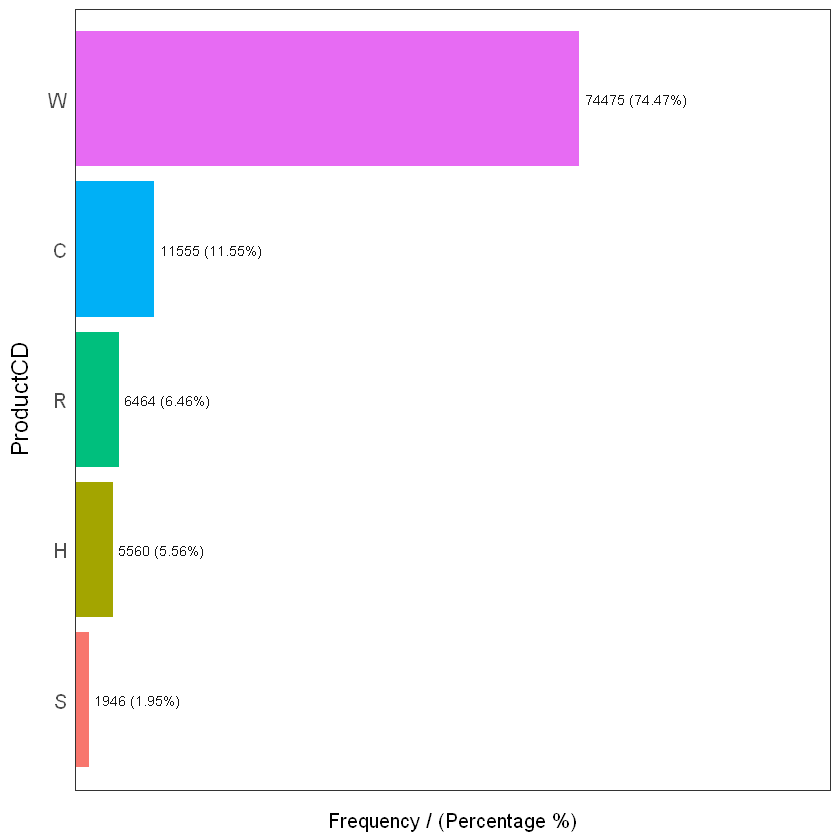

             card4 frequency percentage cumulative_perc
1             visa     65073      65.07           65.07
2       mastercard     32159      32.16           97.23
3 american express      1384       1.38           98.61
4         discover      1121       1.12           99.73
5             <NA>       263       0.26          100.00



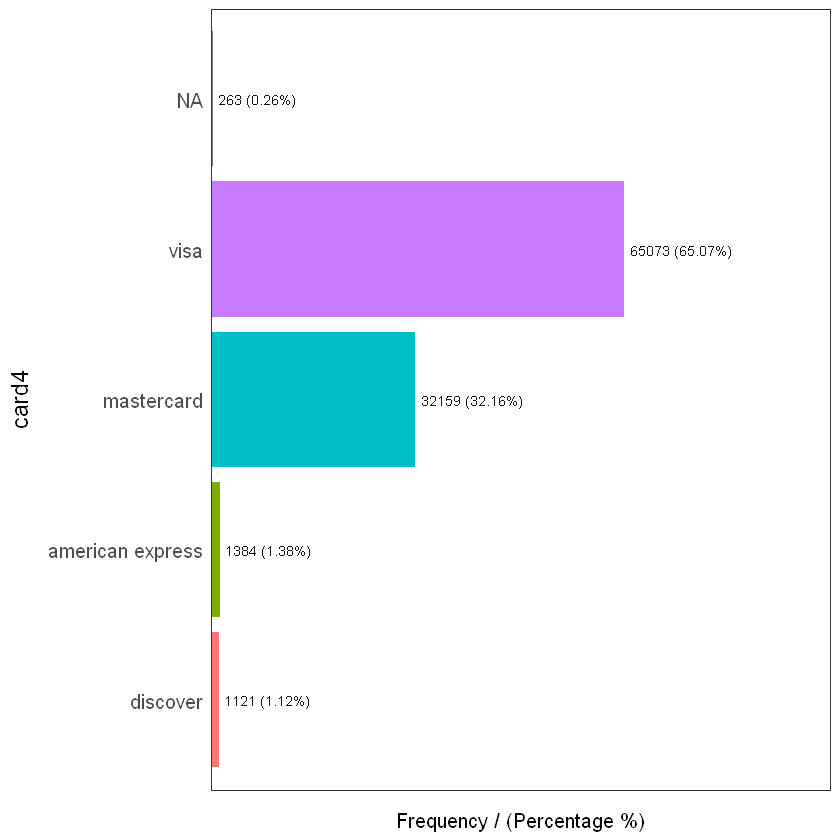

            card6 frequency percentage cumulative_perc
1           debit     74511      74.51           74.51
2          credit     25218      25.22           99.73
3            <NA>       263       0.26           99.99
4 debit or credit         6       0.01          100.00
5     charge card         2       0.00          100.00



[1] "Variables processed: ProductCD, card4, card6"

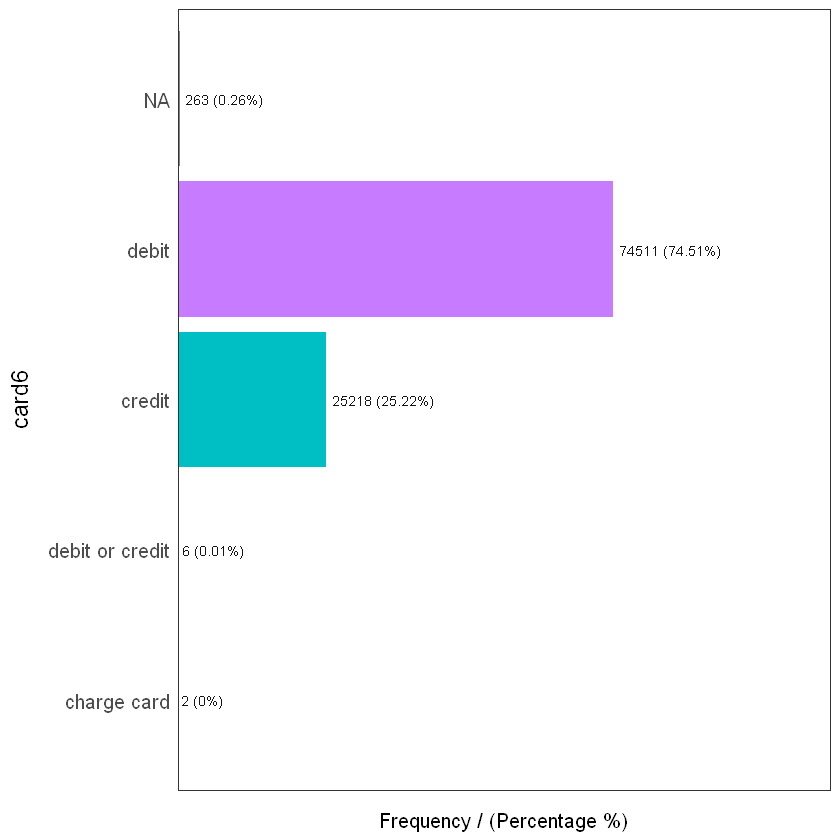

In [11]:
freq(df)

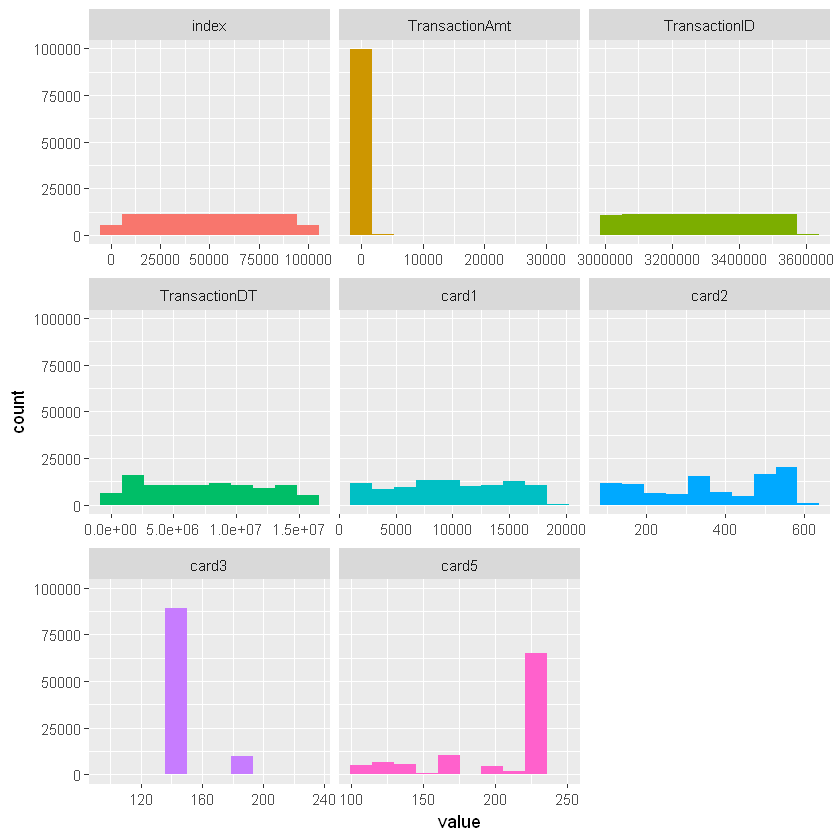

In [12]:
plot_num(df)

In [13]:


range(df$TransactionAmt)

[1]     0.424 31937.391

Warning message:
"Removed 21066 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


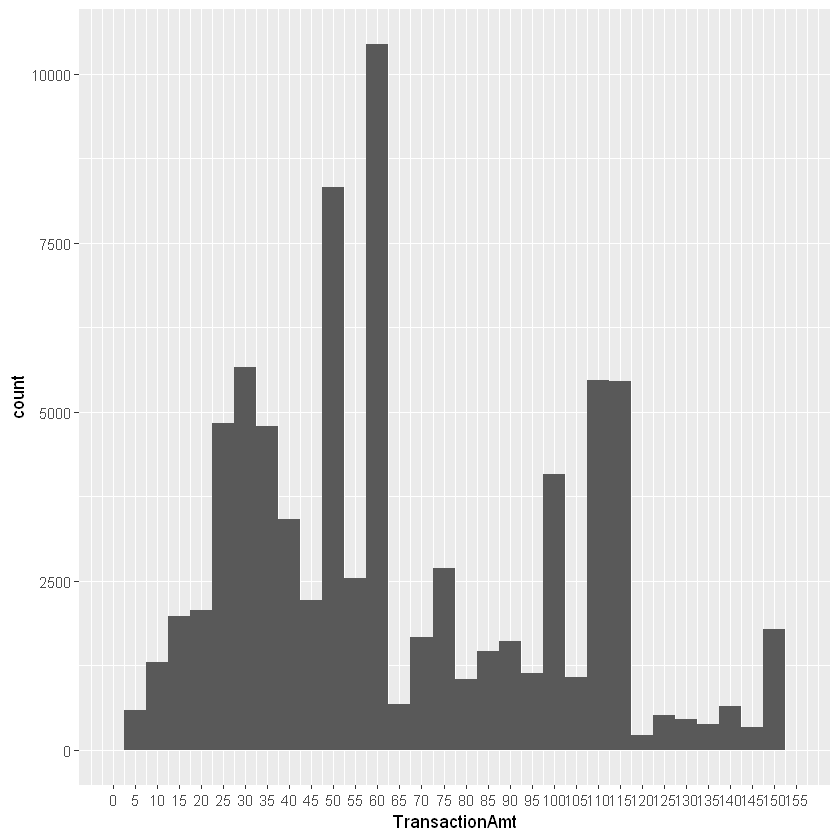

In [14]:
ggplot(df, aes(x = TransactionAmt)) + geom_histogram(binwidth = 5) +
    scale_x_continuous(breaks = seq(0, 155, 5), lim = c(0, 155))


Benford

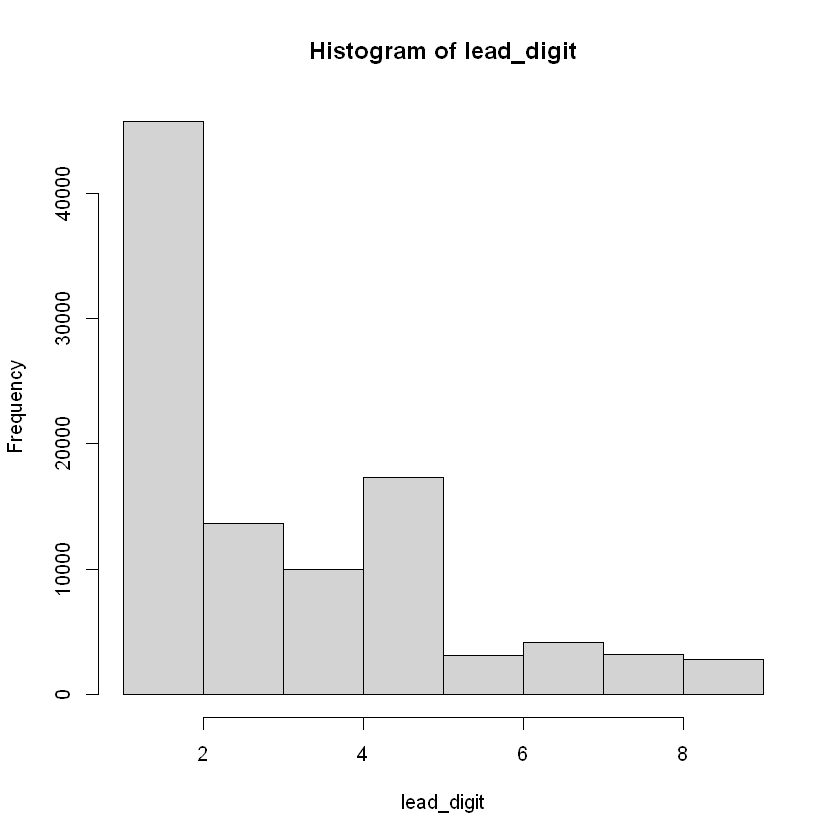

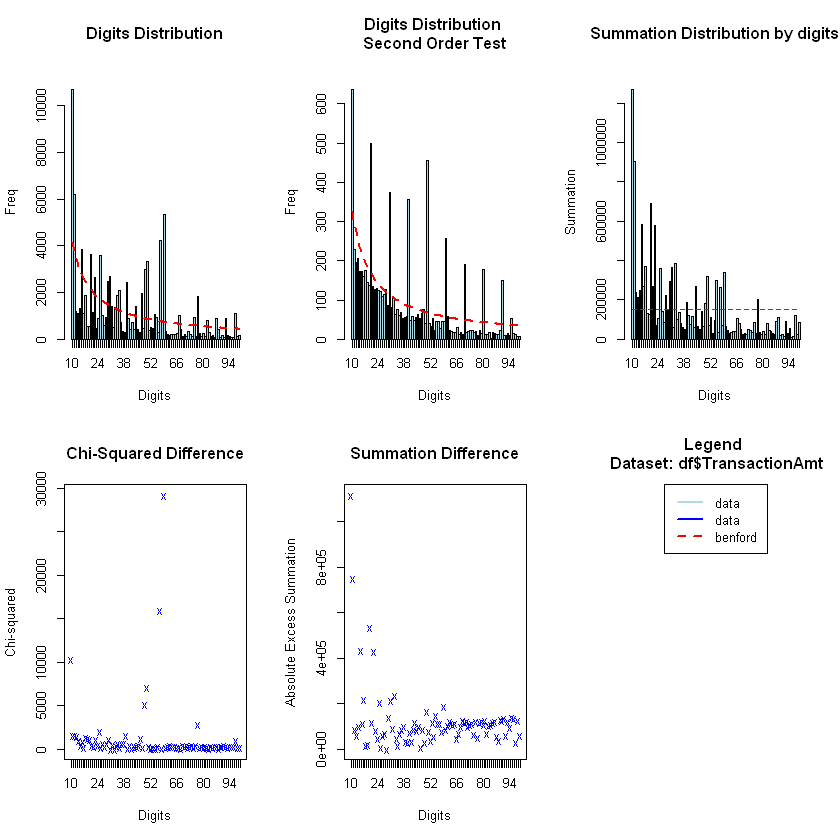

In [15]:
lead_digit <- extract.digits(df$TransactionAmt, number.of.digits=1)
lead_digit <- lead_digit[,2]
hist(lead_digit, breaks=9)
ben <- benford(df$TransactionAmt, number.of.digits=2)
plot(ben)

ilk 2 digiti sırasıyla 4 ve 9 olan transactionların normalden çok daha fazla olduğu gözlemleniyor.


49 ile başlayan gözlemleri veri setinden çekiyoruz ve raporlamaya hazır hale getiriyoruz.

In [16]:
lead_digit <- extract.digits(df$TransactionAmt, number.of.digits=2)
customer_check <- cbind(df,lead_digit) 

PossibleFraud<-customer_check[customer_check$data.digits ==49 ,] %>%
  arrange(index) %>% 
  select(index, TransactionAmt)

PossibleFraud

index,TransactionAmt
<int>,<dbl>
9,49.00
60,49.00
105,49.00
171,49.00
181,49.00
184,49.00
186,49.00
228,49.00
342,49.00
